In [9]:
!pip install rdkit
!pip install dgl
!pip install networkx

You should consider upgrading via the 'C:\Users\qinghegao\git\AI-in-Bio-Chemical-Engineering-Lecture-Coding\venv\Scripts\python.exe -m pip install --upgrade pip' command.



  Using cached dgl-2.0.0-cp39-cp39-win_amd64.whl (4.6 MB)
  Using cached torchdata-0.7.1-cp39-cp39-win_amd64.whl (1.3 MB)


You should consider upgrading via the 'C:\Users\qinghegao\git\AI-in-Bio-Chemical-Engineering-Lecture-Coding\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Molecualr descriptors

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw # For 2D representation of molecule


# Create a molecule object for benzene
benzene = Chem.MolFromSmiles('C1=CC=CC=C1')

# Adding H-atoms to fulfil valency of C -atom 
benzene =  Chem.AddHs (benzene)

# Visualize molecule in 2D
mol_image = Draw.MolToImage (benzene) 
mol_image.show()

# Calculate some molecular descriptors for benzene
molecular_weight = Descriptors.MolWt(benzene)
num_rings = Descriptors.RingCount(benzene)


print('Benzene has molecular weight: ', molecular_weight)
print('Benzene has the number of ring: ', num_rings)


## Molecular graph

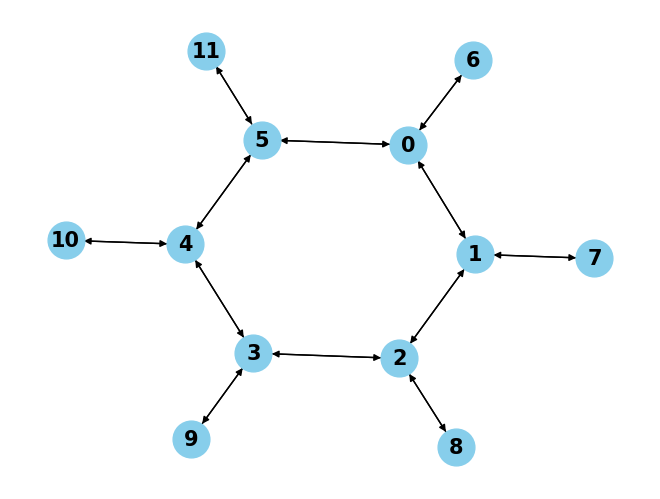

Graph(num_nodes=12, num_edges=24,
      ndata_schemes={'atom_type': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={'bond_type': Scheme(shape=(2,), dtype=torch.int64)})
Node features:
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])

Edge features:
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])


In [6]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import torch

# Benzene SMILES string
smiles_string = 'C1=CC=CC=C1'

# Convert SMILES string to RDKit molecule
molecule = Chem.MolFromSmiles(smiles_string)

# adding H-atoms to fulfil valency of C -atom
molecule = Chem.AddHs(molecule)
# Draw the molecule
Draw.MolToImage(molecule)

# Initialize an empty directed NetworkX graph
G = nx.DiGraph()

# Define a function for one-hot encoding
def one_hot_encode(value, options):
    """
    One-hot encode a given value based on the provided options.

    Parameters:
        value: The value to encode (e.g., a string, number, etc.).
        options: A list of all possible options/categories.

    Returns:
        A list representing the one-hot encoded vector. If the value is not
        in the options, it appends a 0 for the missing value.
    """
    encoding = [1 if value == option else 0 for option in options]
    # If the value is not in categories, the entire encoding will be 0
    if sum(encoding) == 0:
        encoding.append(0)  # Add a "not found" indicator
    return encoding

# Dynamically extract all atom types and bond types from the molecule
atom_types = list(set([atom.GetSymbol() for atom in molecule.GetAtoms()]))
bond_types = list(set([bond.GetBondType() for bond in molecule.GetBonds()]))

# Adding nodes with atom type as a feature
for atom in molecule.GetAtoms():
    atom_idx = atom.GetIdx()
    atom_type = atom.GetSymbol()
    one_hot_atom_type = one_hot_encode(atom_type, atom_types)
    G.add_node(atom_idx, atom_type=one_hot_atom_type)

# Adding edges with bond type as a feature
for bond in molecule.GetBonds():
    bond_type = bond.GetBondType()
    begin_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    one_hot_bond_type = one_hot_encode(bond_type, bond_types)

    # Add directed edges with features for both directions
    G.add_edge(begin_idx, end_idx, bond_type=one_hot_bond_type)
    G.add_edge(end_idx, begin_idx, bond_type=one_hot_bond_type)

# Visualize the graph using NetworkX
pos = nx.spring_layout(G)  # Layout for consistent visualization
nx.draw(
    G, pos, with_labels=True, node_color='skyblue',
    node_size=700, font_size=15, font_weight='bold'
)
plt.show()

# Convert the NetworkX graph to a DGL graph with node and edge features
dgl_graph = dgl.from_networkx(
    G,
    node_attrs=['atom_type'],
    edge_attrs=['bond_type']
)

# Print graph information
print(dgl_graph)

# Access node and edge features
print("Node features:")
print(dgl_graph.ndata['atom_type'])  # One-hot encoded atom types

print("\nEdge features:")
print(dgl_graph.edata['bond_type'])  # One-hot encoded bond types


# Graph Neural Network

In [7]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv

class SimpleGCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(SimpleGCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        # g is the graph and inputs is the input node features
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# Example usage
# Assume a graph `g` and input features `features` are already defined
# g = Your graph
# features = Your input node features as a PyTorch tensor
# Initialize the model
model = SimpleGCN(in_feats=1, hidden_size=16, num_classes=2)
print(model)

SimpleGCN(
  (conv1): GraphConv(in=1, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=2, normalization=both, activation=None)
)
